## Integrated ETL Pipeline and Interactive PowerBI Dashboard for Bank Marketing Insights

---

In the realm of bank marketing analytics, this project offers a seamless transition from raw data to insightful visualization. By utilizing bank marketing data from CSV files, an ETL pipeline was established with the aid of Python and Pandas, ensuring efficient data processing. Following transformation, data found its place in a PostgreSQL database, organized with a structured schema for optimal querying. The culmination of these processes is an interactive PowerBI dashboard, illuminating bank marketing trends and metrics. The inherent integration between the ETL workflow and the PowerBI dashboard guarantees real-time analytics and comprehensive reporting

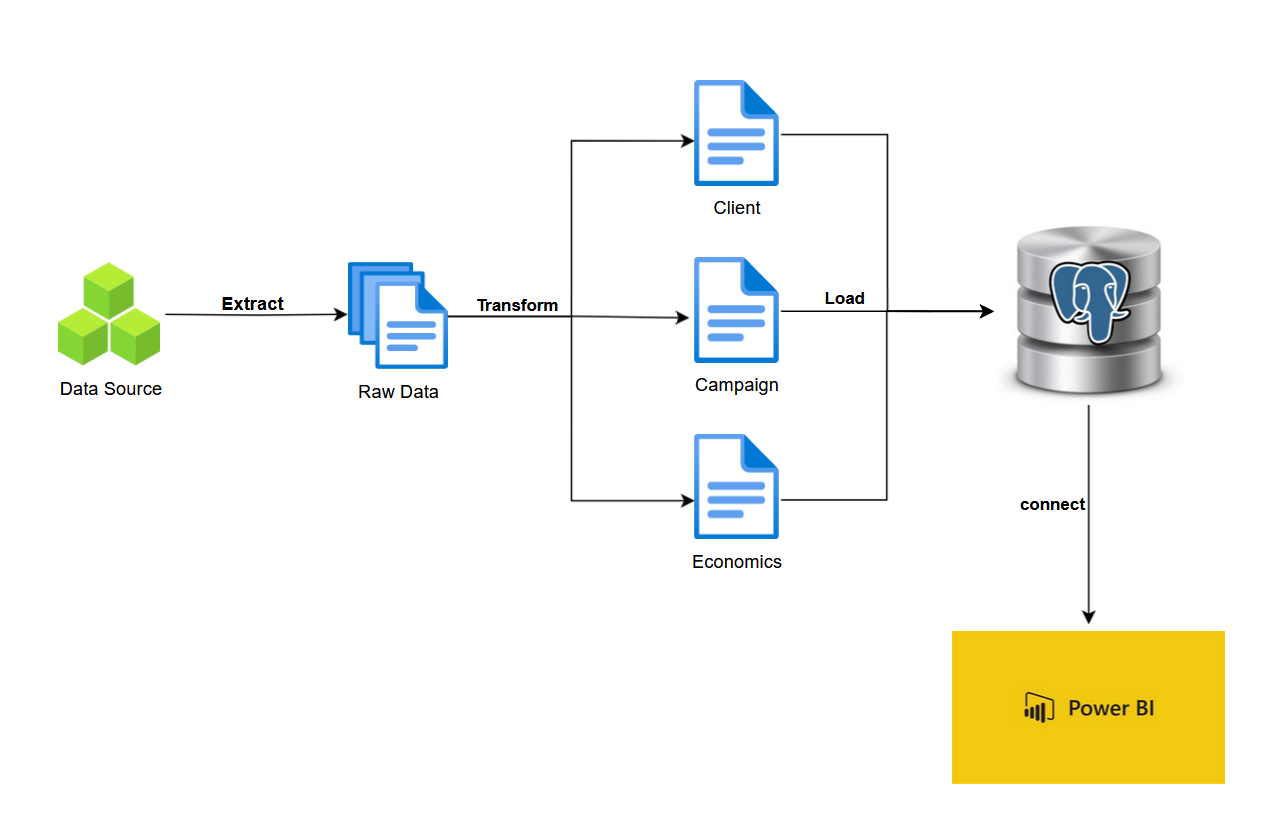

Image below delves into the structured database schema within PostgreSQL. It showcases three pivotal tables: 'client', 'campaign', and 'economics'. Central to this structure is the 'client' table, identified by its primary key 'client_id'. This key not only serves as the main identifier within the 'client' table but also plays a crucial role as a foreign key in both the 'campaign' and 'economics' tables, ensuring data consistency and establishing relationships between the tables

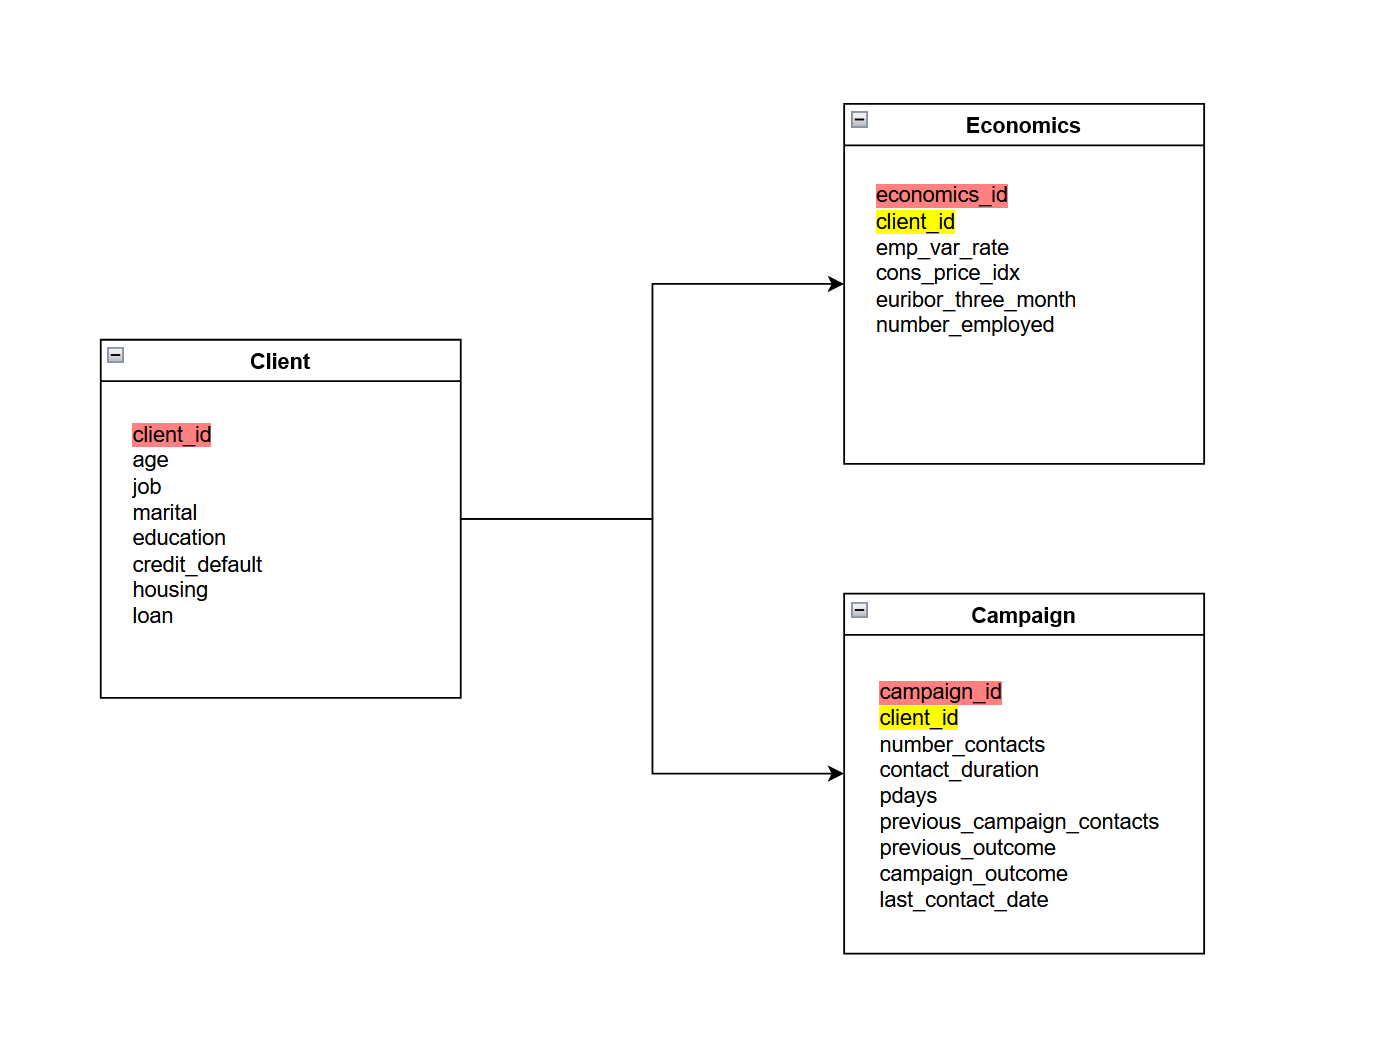

---

## <center> 1. Extraction

In [1]:
import psycopg2
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("bank_marketing.csv")
df.head()

,client_id,age,job,marital,education,credit_default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,0,56,housemaid,married,basic.4y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,1,57,services,married,high.school,unknown,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,2,37,services,married,high.school,no,yes,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,3,40,admin.,married,basic.6y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,4,56,services,married,high.school,no,no,yes,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.columns

Index(['client_id', 'age', 'job', 'marital', 'education', 'credit_default',
       'housing', 'loan', 'contact', 'month', 'day', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

In [4]:
client = df[["client_id", "age", "job", "marital", "education", "credit_default", "housing", "loan"]].copy()
campaign = df[["client_id", "campaign", "month", "day", "duration", "pdays", "previous", "poutcome", "y"]].copy()
economics = df[["client_id", "emp_var_rate", "cons_price_idx", "euribor3m", "nr_employed"]].copy()

In [5]:
# Rename duration, y, and campaign columns
campaign.rename(columns={"duration": "contact_duration", 
                         "y": "campaign_outcome", 
                         "campaign": "number_contacts",
                         "previous": "previous_campaign_contacts",
                         "poutcome": "previous_outcome"}, 
                         inplace=True)

# Rename euribor3m and nr_employed
economics.rename(columns={"euribor3m": "euribor_three_months", 
                          "nr_employed": "number_employed"}, 
                          inplace=True)

---

## <center> 2. Transformation

### a. Client

In [6]:
client.head()

,client_id,age,job,marital,education,credit_default,housing,loan
0,0,56,housemaid,married,basic.4y,no,no,no
1,1,57,services,married,high.school,unknown,no,no
2,2,37,services,married,high.school,no,yes,no
3,3,40,admin.,married,basic.6y,no,no,no
4,4,56,services,married,high.school,no,no,yes


In [7]:
client.dtypes

client_id          int64
age                int64
job               object
marital           object
education         object
credit_default    object
housing           object
loan              object
dtype: object

In [8]:
def print_value_counts(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            print(f"Value counts for column: '{column}':")
            print(df[column].value_counts())
            print("\n")
print_value_counts(client)

Value counts for column: 'job':
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64


Value counts for column: 'marital':
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64


Value counts for column: 'education':
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64


Value counts for column: 'credit_default':
no         32588
unknown     8597
yes            3
Name: credit_default, dtype: int64


Value counts for column: 'housing':
yes        21576
no         18622
unknown      990
Name: ho

In [9]:
#removing unnecessary '.' in entries of column "education" and "job"
client["education"] = client["education"].str.replace(".", " ", regex=True)
client["job"] = client["job"].str.replace(".", "", regex=True)

In [10]:
# Identify columns with 'unknown'
cols_with_unknown = client.columns[client.apply(lambda col: col.value_counts().get('unknown', 0) > 0)]

# Replace 'unknown' with NaN in those columns
client[cols_with_unknown] = client[cols_with_unknown].replace('unknown', np.nan)

In [11]:
# Identify columns with 'yes' or 'no'
cols_with_yes_no = client.columns[client.apply(lambda col: col.value_counts().get('yes', 0) > 0 or col.value_counts().get('no', 0) > 0)]

# Replace 'yes' with 1 and 'no' with 0 in those columns, then convert to integer
for col in cols_with_yes_no:
    client[col] = client[col].replace({'yes': 1, 'no': 0})

In [12]:
client.head()

,client_id,age,job,marital,education,credit_default,housing,loan
0,0,56,housemaid,married,basic 4y,0.0,0.0,0.0
1,1,57,services,married,high school,NaN,0.0,0.0
2,2,37,services,married,high school,0.0,1.0,0.0
3,3,40,admin,married,basic 6y,0.0,0.0,0.0
4,4,56,services,married,high school,0.0,0.0,1.0


In [13]:
client.dtypes

client_id           int64
age                 int64
job                object
marital            object
education          object
credit_default    float64
housing           float64
loan              float64
dtype: object

### b. Campaign

In [14]:
campaign.head()

,client_id,number_contacts,month,day,contact_duration,pdays,previous_campaign_contacts,previous_outcome,campaign_outcome
0,0,1,may,13,261,999,0,nonexistent,no
1,1,1,may,19,149,999,0,nonexistent,no
2,2,1,may,23,226,999,0,nonexistent,no
3,3,1,may,27,151,999,0,nonexistent,no
4,4,1,may,3,307,999,0,nonexistent,no


In [15]:
campaign.dtypes

client_id                      int64
number_contacts                int64
month                         object
day                            int64
contact_duration               int64
pdays                          int64
previous_campaign_contacts     int64
previous_outcome              object
campaign_outcome              object
dtype: object

In [16]:
print_value_counts(campaign)

Value counts for column: 'month':
may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64


Value counts for column: 'previous_outcome':
nonexistent    35563
failure         4252
success         1373
Name: previous_outcome, dtype: int64


Value counts for column: 'campaign_outcome':
no     36548
yes     4640
Name: campaign_outcome, dtype: int64




In [17]:
campaign['campaign_id'] = campaign.index

In [18]:
campaign["previous_outcome"] = campaign["previous_outcome"].replace("nonexistent", np.NaN)

In [19]:
campaign["previous_outcome"] = campaign["previous_outcome"].replace({'success': 1, 'failure': 0})
campaign["campaign_outcome"] = campaign["campaign_outcome"].replace({'yes': 1, 'no': 0})

In [20]:
# Capitalize month and day columns
campaign["month"] = campaign["month"].str.capitalize()

In [21]:
# Add year column
campaign["year"] = "2023"

In [22]:
# Convert day to string
campaign["day"] = campaign["day"].astype(str)

# Add last_contact_date column
campaign["last_contact_date"] =campaign["day"]   + "-" + campaign["month"]    + "-" + campaign["year"]

# Convert to datetime
campaign["last_contact_date"] = pd.to_datetime(campaign["last_contact_date"], 
                                               format="%d-%b-%Y")

In [23]:
# Drop unneccessary columns
campaign.drop(columns=["month", "day", "year"], inplace=True)

In [24]:
campaign.head()

,client_id,number_contacts,contact_duration,pdays,previous_campaign_contacts,previous_outcome,campaign_outcome,campaign_id,last_contact_date
0,0,1,261,999,0,NaN,0,0,2023-05-13
1,1,1,149,999,0,NaN,0,1,2023-05-19
2,2,1,226,999,0,NaN,0,2,2023-05-23
3,3,1,151,999,0,NaN,0,3,2023-05-27
4,4,1,307,999,0,NaN,0,4,2023-05-03


In [25]:
cols = list(campaign.columns)
cols.remove('campaign_id')
cols.insert(0, 'campaign_id')
campaign = campaign[cols]

In [26]:
campaign.head()

,campaign_id,client_id,number_contacts,contact_duration,pdays,previous_campaign_contacts,previous_outcome,campaign_outcome,last_contact_date
0,0,0,1,261,999,0,NaN,0,2023-05-13
1,1,1,1,149,999,0,NaN,0,2023-05-19
2,2,2,1,226,999,0,NaN,0,2023-05-23
3,3,3,1,151,999,0,NaN,0,2023-05-27
4,4,4,1,307,999,0,NaN,0,2023-05-03


In [27]:
n = len(campaign.columns)
print("%s, "*n)

%s, %s, %s, %s, %s, %s, %s, %s, %s, 


### c. Economics

In [28]:
economics.head()

,client_id,emp_var_rate,cons_price_idx,euribor_three_months,number_employed
0,0,1.1,93.994,4.857,5191.0
1,1,1.1,93.994,4.857,5191.0
2,2,1.1,93.994,4.857,5191.0
3,3,1.1,93.994,4.857,5191.0
4,4,1.1,93.994,4.857,5191.0


In [29]:
economics.dtypes

client_id                 int64
emp_var_rate            float64
cons_price_idx          float64
euribor_three_months    float64
number_employed         float64
dtype: object

In [30]:
economics['economics_id'] = economics.index

In [31]:
cols = list(economics.columns)
cols.remove('economics_id')
cols.insert(0, 'economics_id')
economics = economics[cols]

In [32]:
economics.head()

,economics_id,client_id,emp_var_rate,cons_price_idx,euribor_three_months,number_employed
0,0,0,1.1,93.994,4.857,5191.0
1,1,1,1.1,93.994,4.857,5191.0
2,2,2,1.1,93.994,4.857,5191.0
3,3,3,1.1,93.994,4.857,5191.0
4,4,4,1.1,93.994,4.857,5191.0


---

## <center> 3. Load

In [33]:
def create_database():
    conn = psycopg2.connect("host=127.0.0.1 dbname=postgres user=postgres password=1234") #initial connection
    conn.set_session(autocommit=True) #enable autocommit
    cur = conn.cursor() #create cursor object
    
    cur.execute("CREATE DATABASE marketing") #create new databse
    
    conn.close() #intial connection to postgres database is closed
    conn = psycopg2.connect("host=127.0.0.1 dbname=marketing user=postgres password=1234") #connect to new database
    cur = conn.cursor()
    
    return cur, conn

In [34]:
cur, conn = create_database()

### a. Client Table

In [35]:
client_table_create = ("""CREATE TABLE IF NOT EXISTS client(
client_id numeric PRIMARY KEY,
age numeric,
job VARCHAR, 
marital VARCHAR,
education VARCHAR,
credit_default numeric,
housing numeric,
loan numeric)""")

cur.execute(client_table_create)
conn.commit()

client_table_insert = ("""
INSERT INTO client(client_id, age, job, marital, education, credit_default, housing, loan)
VALUES (%s, %s, %s, %s, %s, %s, %s, %s )
""")

for i, row in client.iterrows():
    cur.execute(client_table_insert, list(row))
conn.commit()

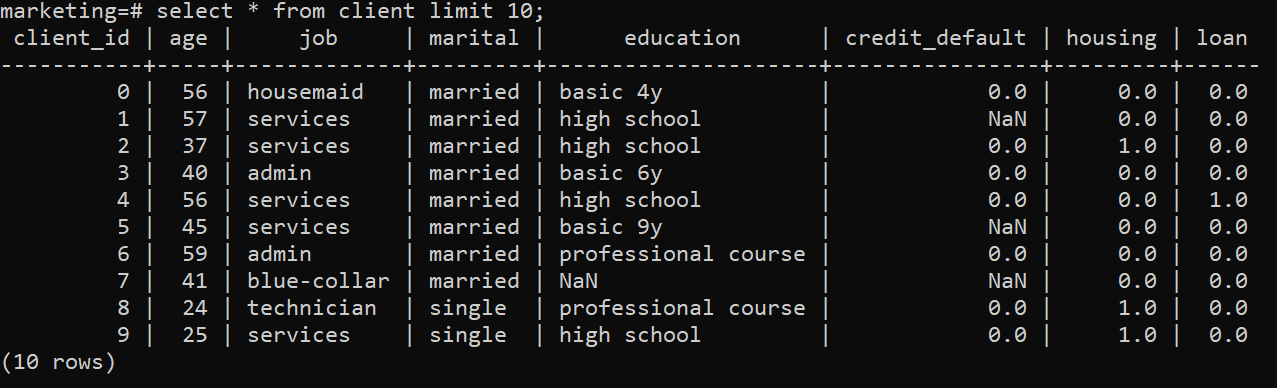

### b. Campaign Table

In [36]:
campaign_table_create = ("""CREATE TABLE IF NOT EXISTS campaign(
campaign_id numeric PRIMARY KEY,
client_id numeric,
number_contacts numeric,
contact_duration numeric,
pdays numeric,
previous_campaign_contacts numeric,
previous_outcome numeric, 
campaign_outcome numeric,
last_contact_date TIMESTAMP,
FOREIGN KEY(client_id) REFERENCES client(client_id))""")

cur.execute(campaign_table_create)
conn.commit()

campaign_table_insert = ("""
INSERT INTO campaign(campaign_id, client_id, number_contacts, contact_duration, pdays, previous_campaign_contacts, previous_outcome, campaign_outcome, last_contact_date)
VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
""")

for i, row in campaign.iterrows():
    cur.execute(campaign_table_insert, list(row))
conn.commit()

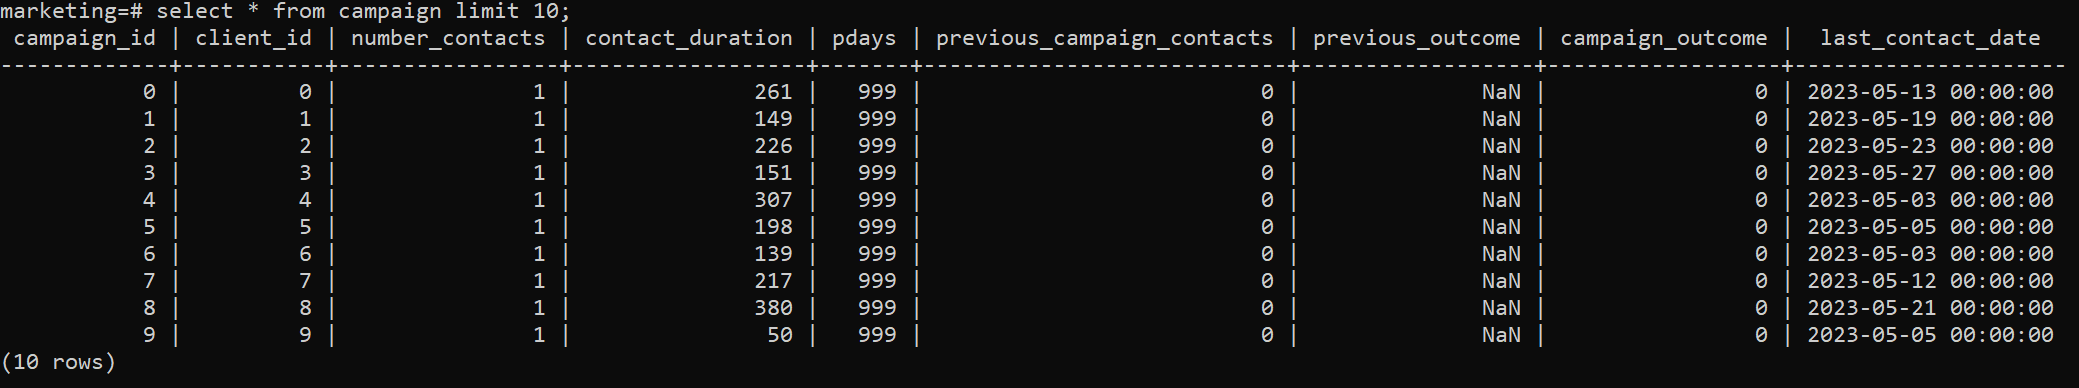

### c. Economics

In [37]:
economics_table_create = ("""CREATE TABLE IF NOT EXISTS economics(
economics_id numeric PRIMARY KEY,
client_id numeric,
emp_var_rate numeric,
cons_price_idx numeric,
euribor_three_months numeric,
number_employed numeric,
FOREIGN KEY(client_id) REFERENCES client(client_id))""")

cur.execute(economics_table_create)
conn.commit()

economics_table_insert = ("""
INSERT INTO economics(economics_id, client_id, emp_var_rate, cons_price_idx, euribor_three_months, number_employed)
VALUES (%s, %s, %s, %s, %s, %s)
""")

for i, row in economics.iterrows():
    cur.execute(economics_table_insert, list(row))
conn.commit()

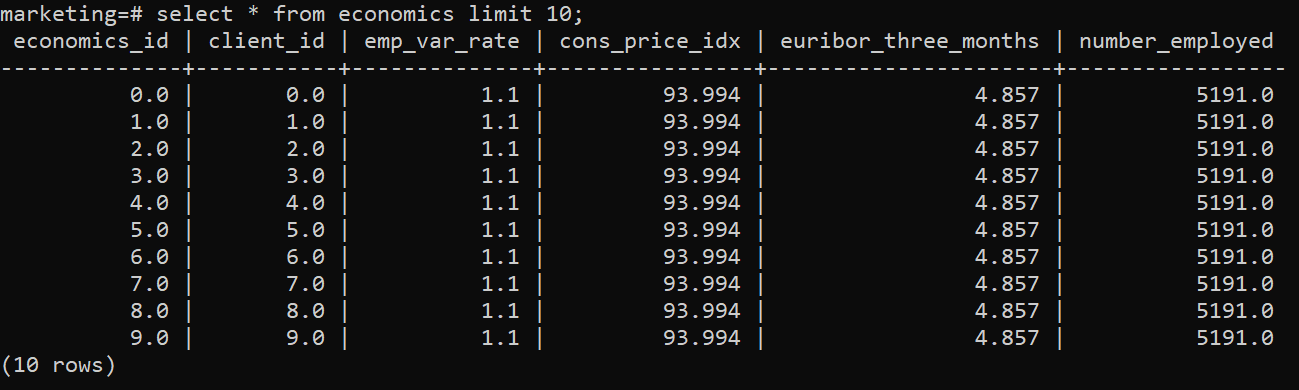

---

In wrapping up the project, it's evident that the carefully designed database, with its interlinked tables 'client', 'campaign', and 'economics', forms the backbone of our analytics platform. The role of 'client_id', both as a primary and foreign key, underscores the importance of data integrity and connectivity.

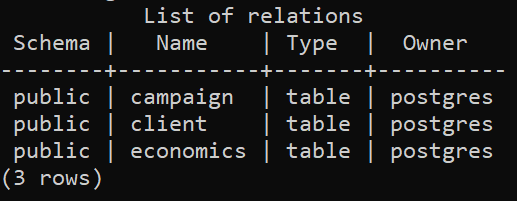 

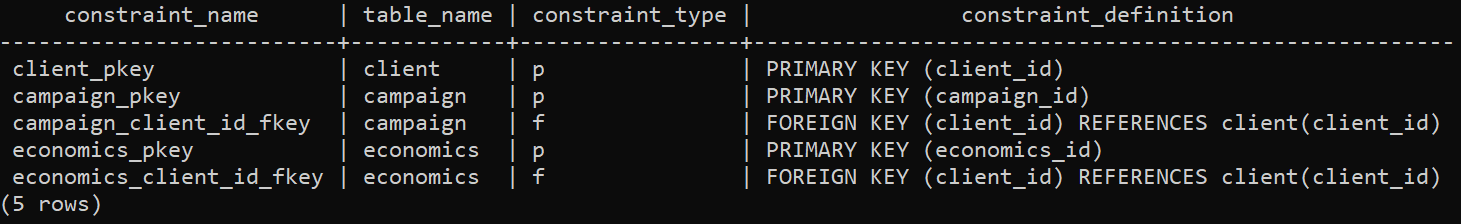

---